<a href="https://colab.research.google.com/github/anncam/Transformers/blob/main/transformers_hotel_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Packages Required

In [ ]:
!pip3 install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 33.7 MB/s 
     |████████████████████████████████| 981 kB 47.2 MB/s 
     |████████████████████████████████| 263 kB 32.7 MB/s 
     |████████████████████████████████| 3.8 MB 40.2 MB/s 
     |████████████████████████████████| 1.3 MB 29.5 MB/s 
     |████████████████████████████████| 468 kB 33.6 MB/s 
     |████████████████████████████████| 182 kB 36.4 MB/s 
     |████████████████████████████████| 7.6 MB 56.6 MB/s 
     |████████████████████████████████| 880 kB 59.5 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.10-py3-none-any.whl size=25312982 sha256=0cb0387fc43c1c0fcd09f3e982f9a7a83ebf836b99f46a8ea6c688f37527192a
  Stored in directory: /root/.cache/pip/wheels/9c/1c/1b/6df2db85720b8f5c6ea5e3ae37313cfc656f248abf910b7cfd
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33516 sha256=b217fe58c521c49ddeabb1

In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import plotly.graph_objects as go
#import plotly.express as px
import matplotlib.pyplot as plt
import spacy
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS 
import ktrain
from ktrain import text

from collections import Counter
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df = pd.read_csv('../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
df = pd.read_csv('drive/My Drive/Colab Notebooks/data/tripadvisor_hotel_reviews.csv')
df.head()



,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
df.shape

(20491, 2)

In [ ]:
df.isnull().sum().any()

False

# Sentiment Visualisation

In [ ]:
pos = [4, 5]
neg = [1, 2]
neu = [3]

def sentiment(rating):
  if rating in pos:
    return 2
  elif rating in neg:
    return 0
  else:
    return 1  

In [ ]:
df['Sentiment'] = df['Rating'].apply(sentiment)
df.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,2
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,2
4,"great stay great stay, went seahawk game aweso...",5,2


In [ ]:
fig = go.Figure([go.Bar(x=df.Sentiment.value_counts().index, y=df.Sentiment.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

Here,

2 - Positive (4, 5)<br>
1 - Neutral (3)<br>
0 - Negative (1, 2)

Review distrubution seems more inclined in the positive than the negative. The reason I am not going to neutral is cause that is just one rating whereas positive and negative have two ratings.

## Wordclouds of each Sentiment

Let us now look at the word distribution overrall and for each sentiment.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def normalize(msg):
    
    doc = nlp(msg)
    res = []
    
    for token in doc:
        if(token.is_stop or token.is_punct or token.is_space):
            pass
        else:
            res.append(token.lemma_.lower())
            
    return res

In [ ]:
df['Review'] = df['Review'].apply(normalize)
df.head()

,Review,Rating,Sentiment
0,"[nice, hotel, expensive, parking, get, good, d...",4,2
1,"[ok, special, charge, diamond, member, hilton,...",2,0
2,"[nice, room, 4, experience, hotel, monaco, sea...",3,1
3,"[unique, great, stay, wonderful, time, hotel, ...",5,2
4,"[great, stay, great, stay, go, seahawk, game, ...",5,2


In [ ]:
words_collection = Counter([item for sublist in df['Review'] for item in sublist])
freq_word_df = pd.DataFrame(words_collection.most_common(15))
freq_word_df.columns = ['frequently_used_word','count']

freq_word_df.style.background_gradient(cmap='PuBuGn', low=0, high=0, axis=0, subset=None)

,frequently_used_word,count
0,hotel,52918
1,room,46612
2,stay,27744
3,good,21519
4,great,21283
5,staff,16375
6,night,14168
7,day,13035
8,nice,12970
9,time,12197


## Overrall Wordcloud of Reviews 

In [ ]:
word_list = [item for sublist in df['Review'] for item in sublist]
word_string = " ".join(word_list)

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=60000, 
                      width=1000,
                      height=650
                         ).generate(word_string)

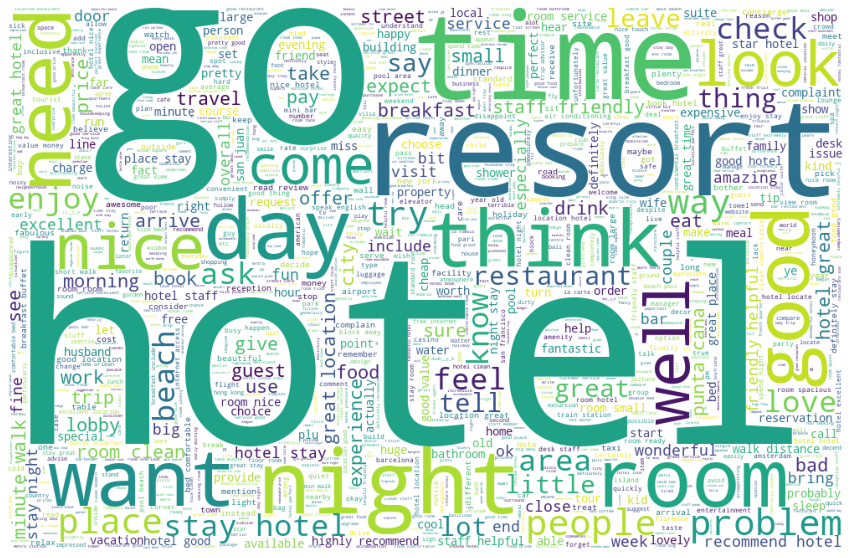

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

As expected, it is a mixture of some good words and not much of the bad reviews. Let's break it down with each sentiment.

## Positive Sentiment Wordcloud

In [ ]:
pos_df = df[df['Sentiment'] == 2]
words_collection = Counter([item for sublist in pos_df['Review'] for item in sublist])
freq_word_df = pd.DataFrame(words_collection.most_common(15))
freq_word_df.columns = ['frequently_used_word','count']

freq_word_df.style.background_gradient(cmap='PuBuGn', low=0, high=0, axis=0, subset=None)

,frequently_used_word,count
0,hotel,38924
1,room,30812
2,stay,20588
3,great,18254
4,good,16081
5,staff,12597
6,night,9697
7,nice,9624
8,location,8879
9,day,8777


In [ ]:
word_list_pos = [item for sublist in pos_df['Review'] for item in sublist]
word_string_pos = " ".join(word_list)

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=40000, 
                      width=1000,
                      height=650
                         ).generate(word_string_pos)

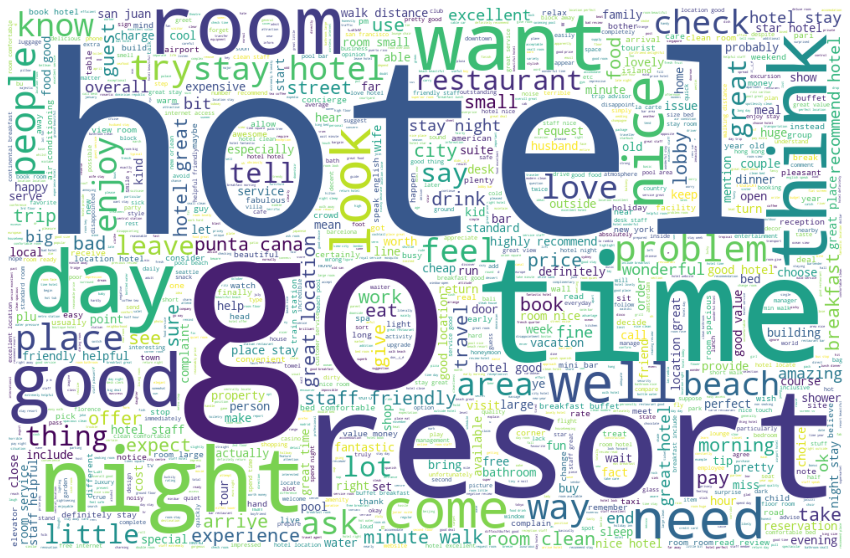

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Positive words like "good", "love", "great" can be seen from this wordcloud

## Neutral Sentiment Wordcloud

In [ ]:
neu_df = df[df['Sentiment'] == 1]
words_collection = Counter([item for sublist in neu_df['Review'] for item in sublist])
freq_word_df = pd.DataFrame(words_collection.most_common(15))
freq_word_df.columns = ['frequently_used_word','count']

freq_word_df.style.background_gradient(cmap='PuBuGn', low=0, high=0, axis=0, subset=None)

,frequently_used_word,count
0,room,5955
1,hotel,5525
2,good,2836
3,stay,2695
4,nice,1824
5,great,1775
6,night,1753
7,day,1498
8,staff,1497
9,location,1431


In [ ]:
word_list_neu = [item for sublist in neu_df['Review'] for item in sublist]
word_string_neu = " ".join(word_list)

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=6000, 
                      width=1000,
                      height=650
                         ).generate(word_string_neu)

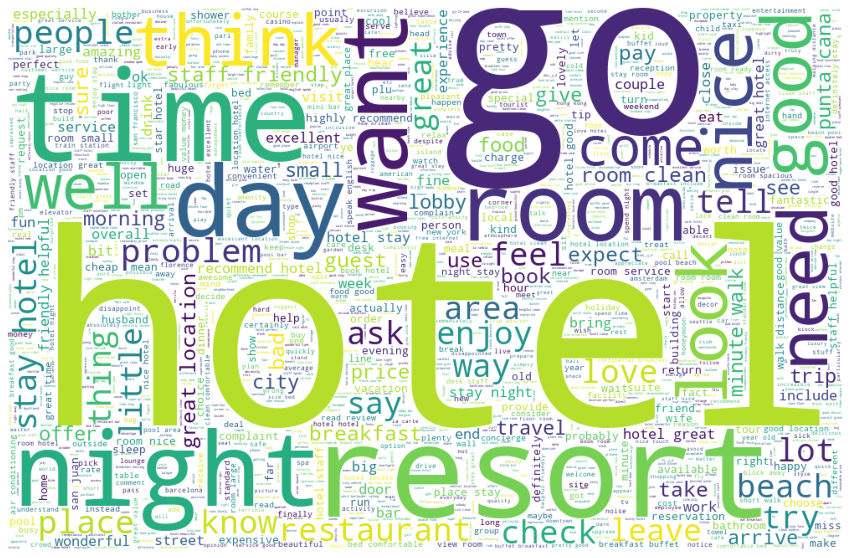

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Ah it seems "problem" sticks out a little here in the neutral reviews. Another word I managed to look into is "expensive". Maybe in future versions we can probably remove the obvious words like hotel and resort.  

## Negative Sentiment Wordcloud

In [ ]:
neg_df = df[df['Sentiment'] == 0]
words_collection = Counter([item for sublist in neg_df['Review'] for item in sublist])
freq_word_df = pd.DataFrame(words_collection.most_common(15))
freq_word_df.columns = ['frequently_used_word','count']

freq_word_df.style.background_gradient(cmap='PuBuGn', low=0, high=0, axis=0, subset=None)

,frequently_used_word,count
0,room,9845
1,hotel,8469
2,stay,4461
3,day,2760
4,night,2718
5,good,2602
6,staff,2281
7,service,2199
8,time,2190
9,go,1869


In [ ]:
word_list_neg = [item for sublist in neg_df['Review'] for item in sublist]
word_string_neg = " ".join(word_list)

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=10000, 
                      width=1000,
                      height=650
                         ).generate(word_string_neg)

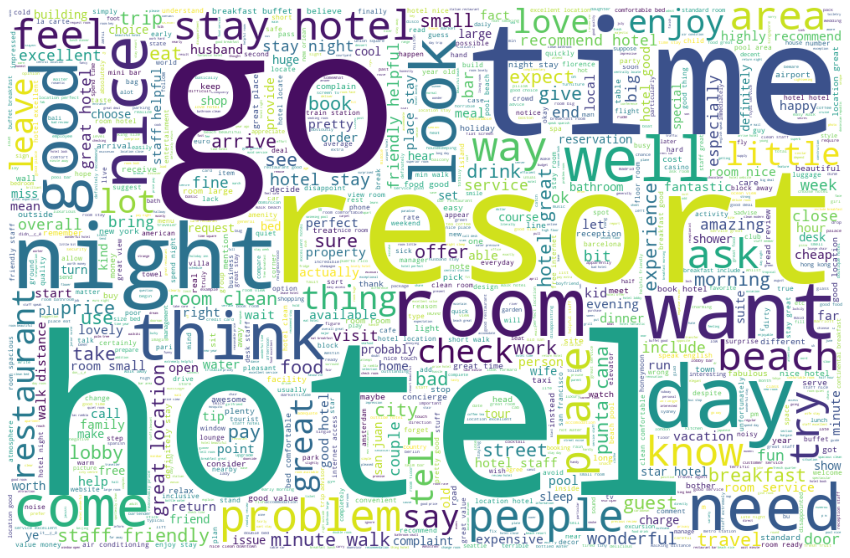

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Some obvious words like "bad", "problem" can be seen in this wordcloud. Maybe when we expand the vocabulary we can clean the text a little better.

The model I am going to be using is the BERT model from the ktrain module. Before we get into the model, we need to turn the lists into strings.

In [ ]:
df['Review'] = df['Review'].apply(lambda m: " ".join(m))
df.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking get good deal sta...,4,2
1,ok special charge diamond member hilton decide...,2,0
2,nice room 4 experience hotel monaco seattle go...,3,1
3,unique great stay wonderful time hotel monaco ...,5,2
4,great stay great stay go seahawk game awesome ...,5,2


# Training BERT model

In [ ]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 
                                                                    'Review',
                                                                    label_columns=['Sentiment'],
                                                                    preprocess_mode='bert')

['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
       Sentiment_0  Sentiment_1  Sentiment_2
9251           0.0          0.0          1.0
7629           0.0          0.0          1.0
2728           1.0          0.0          0.0
3044           1.0          0.0          0.0
16763          0.0          0.0          1.0
['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
       Sentiment_0  Sentiment_1  Sentiment_2
13117          0.0          0.0          1.0
17357          0.0          1.0          0.0
17841          0.0          0.0          1.0
12183          1.0          0.0          0.0
8136           0.0          0.0          1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
model = text.text_classifier(name='bert',
                             train_data=(x_train, y_train),
                             preproc=preproc)

Is Multi-Label? False
maxlen is 400
done.


In [ ]:
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=6)

In [ ]:
learner.fit_onecycle(lr=2e-5,
                     epochs=1)



begin training using onecycle policy with max lr of 2e-05...
3074/3074 [==============================] - 1964s 632ms/step - loss: 0.4097 - accuracy: 0.8457 - val_loss: 0.3117 - val_accuracy: 0.8780


#Notes

Slightly lower accuracy when dealing with more clean data in BERT with 84.57% in Training and 87.8% in Validation. <br>
